In this notebook, I will use data from Kaggle on the RMS Titanic to try and predict which types of people would be most likely to have survived the sinking of the Titanic.

For this I will follow the Machine Learning Project Checklist found in "[Hands-On Machine Learning with Scikit-Learn and TensorFlow](http://shop.oreilly.com/product/0636920052289.do)"

<br/>

**Contents:**
1. Frame the Problem and Look at Big Picture
2. Get the Data
3. Explore the Data
4. Prepare the Data
5. Short-List Promising Models
6. Fine-Tune the System
7. Present Solution

Start off with the imports that we will need

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

> # **1.  Frame the Problem and Look at Big Picture**

**Objective:** Create a model to predict who would and who would not have survived the titanic. 

Let's frame this problem:
* This is a **supervised learning problem** due to the fact that we have been given the correct labels (survived or not)
* This is a **classification task** given that we are just trying to predict whether someone survived or not
* This is a **batch learning** problem since the dataset is small enough to be kept in memory and we don't have new information coming in.

I will be using **classification error** as my performance measure.

**Assumptions:**
I think that there will be 3 features that could really determine whether someone would have survived or not:
1.  **Sex**, because women were prioritized in the evacuation
2.  **Age**, because children were also prioritized in the evacuation
3.  **Pclass** (Ticket class), because those who were wealthier probably had more pull to try to get off the ship first over the poor people

Another other minor assumptions that I had are that people higher up on the boat (the **Cabin** feature) would be more likely to survive since when the ship hit the iceburg, obviously the lower level cabins would get hit first.  I am not sure if the **Cabin** feature could help us with this, **Pclass** might help in the same exact way since most of the nicer and more expensive cabins are high up the boat.  

# **2.  Get the Data**

Source: https://www.kaggle.com/c/titanic

In [2]:
titanic_train = pd.read_csv("../input/train.csv")
titanic_train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


And let's get our test set that we won't touch until the end

In [3]:
titanic_test = pd.read_csv("../input/test.csv")

# **3.  Explore the Data**

Now let's explore the data.  Let's make a copy so that we don't accidentally mess up any of our data

In [4]:
titanic = titanic_train.copy()

Let's start exploring

In [5]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Let's start by exploring each attribute one at a time.

## **PassengerId**
<br />
This clearly won't help us at all so we will end up removing it

## **Survived**
<br /> 
This is our target output which is an int being either **1** for survived or **0** for died.  Let's take a look at the distribution

In [6]:
titanic.Survived.value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

As expected, the majority of people did not survive.  Only about 38% did

## **Pclass**

This is our ticket class feature.  It is an int value with one of 3 possible values:
<br />
* 1- 1st class
* 2- 2nd class
* 3- 3rd class
<br />
Yeah, pretty self explanitory, now let's look at the distribution

In [7]:
titanic.Pclass.value_counts(normalize=True)

3    0.551066
1    0.242424
2    0.206510
Name: Pclass, dtype: float64

So the majority of the people on the boat were actually in 3rd class.  This could be a major determining factor in who survived and who died.  Let's look at the distribution of those who survived in each class.

In [8]:
titanic[titanic.Survived == 1].Pclass.value_counts() / titanic.Pclass.value_counts()

1    0.629630
2    0.472826
3    0.242363
Name: Pclass, dtype: float64

As expected, a lot of the people in 1st class survived relative to people in other classes

## **Name**

The name's of the passengers might not tell us too much, but let's look at a sample and see if there is anything that might stand out

In [9]:
titanic.Name.sample(5, random_state=1)

862    Swift, Mrs. Frederick Joel (Margaret Welles Ba...
223                                 Nenkoff, Mr. Christo
84                                   Ilett, Miss. Bertha
680                                  Peters, Miss. Katie
535                               Hart, Miss. Eva Miriam
Name: Name, dtype: object

We do have name prefixes in here, this might be able to help us out with some things.  Let's take a deeper look into the distributions of these prefixes

In [10]:
name_prefixs = titanic.Name.str.extract(',\s?(.*?)\.')
name_prefixs.value_counts()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """Entry point for launching an IPython kernel.


Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Major             2
Mlle              2
Col               2
Jonkheer          1
Sir               1
Ms                1
Mme               1
Don               1
the Countess      1
Capt              1
Lady              1
Name: Name, dtype: int64

In [11]:
print('Survived:')
for prefix in name_prefixs.unique():
    temp = titanic[titanic.Name.str.contains('%s\.' % (prefix))]
    print(prefix, len(temp[temp.Survived == 1]) / len(temp))

Survived:
Mr 0.15667311411992263
Mrs 0.792
Miss 0.6978021978021978
Master 0.575
Don 0.0
Rev 0.0
Dr 0.42857142857142855
Mme 1.0
Ms 1.0
Major 0.5
Lady 1.0
Sir 1.0
Mlle 1.0
Col 0.5
Capt 0.0
the Countess 1.0
Jonkheer 0.0


As expected, the majority of women survived.  It does seem that there is a higher probablity of your survival as a woman if you are married (Mrs) vs not married (Miss).  Also, we can see that the only about 16% of males with prefix Mr survived.  I would assume that most Masters and Doctors at this time period were also males and 58% and 43% of them survived respectively.  This could actually really help us when classifying.  But first we need to look at **Sex** to check if these assumptions are right.

## **Sex**

First let's just look at the distribution of males and females on the ship

In [12]:
titanic.Sex.value_counts(normalize=True)

male      0.647587
female    0.352413
Name: Sex, dtype: float64

So about 2/3 of the ship was male.  Let's look at how many in each survived

In [13]:
titanic[titanic.Survived == 1].Sex.value_counts() / titanic.Sex.value_counts()

female    0.742038
male      0.188908
Name: Sex, dtype: float64

As expected, about 74% of females survived whereas only about 19% of the males survived.  Let's take a look at the prefix of the **Name** along with **Sex**

## **Name Prefix and Sex**

As mentioned in the **Name** analysis, I assumed that the prefix Master and Dr were generally more likely to be males, let's take a look at this

In [14]:
print('Master:')
print(titanic[titanic.Name.str.contains('Master\.')].Sex.value_counts())
print('\n')
print('Dr:')
print(titanic[titanic.Name.str.contains('Dr\.')].Sex.value_counts())

Master:
male    40
Name: Sex, dtype: int64


Dr:
male      6
female    1
Name: Sex, dtype: int64


As expected, Master was all males and as we saw in the **Name** analysis, about 56% of them survived whereas only about 19% of males survived.  This could really help us when making our model.  As for doctor, lets just take a look at these doctors

In [15]:
titanic[titanic.Name.str.contains('Dr\.')]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
245,246,0,1,"Minahan, Dr. William Edward",male,44.0,2,0,19928,90.0000,C78,Q
317,318,0,2,"Moraweck, Dr. Ernest",male,54.0,0,0,29011,14.0000,NaN,S
398,399,0,2,"Pain, Dr. Alfred",male,23.0,0,0,244278,10.5000,NaN,S
632,633,1,1,"Stahelin-Maeglin, Dr. Max",male,32.0,0,0,13214,30.5000,B50,C
660,661,1,1,"Frauenthal, Dr. Henry William",male,50.0,2,0,PC 17611,133.6500,NaN,S
766,767,0,1,"Brewe, Dr. Arthur Jackson",male,NaN,0,0,112379,39.6000,NaN,C
796,797,1,1,"Leader, Dr. Alice (Farnham)",female,49.0,0,0,17465,25.9292,D17,S


So the one woman doctor that we see survived, we already saw that women were more likely to survive, and if we look at the other 5 doctors, about 40% of them survived.  Now this isn't a lot of data to make a conclusion based on, but it may or may not help later on.  When making our model we will probably make a model that takes into account doctors and one that doesn't to see if it helps our model at all or just overfits to this field.  
<br />
Let's take a look at Mrs vs Miss and see if there is anything that stands out that could highlight the reason for Mrs having a higher survival rate

In [16]:
print('Mrs:')
print(titanic[titanic.Name.str.contains('Mrs\.')].Survived.value_counts())
print('Total:', len(titanic[titanic.Name.str.contains('Mrs\.')]))
print('\n')
print('Miss:')
print(titanic[titanic.Name.str.contains('Miss\.')].Survived.value_counts())
print('Total:', len(titanic[titanic.Name.str.contains('Miss\.')]))

Mrs:
1    99
0    26
Name: Survived, dtype: int64
Total: 125


Miss:
1    127
0     55
Name: Survived, dtype: int64
Total: 182


So looking at this, I think it might just be a coincidence.  Maybe the married women survive more is because they have children?  As we know from the movie they said women and children first, so maybe that could be the reason for the slightly higher survival rate.  We will look into that when we get to the **Parch** feature

## **Age**

Age is one of our features with quite a few missing rows missing values.  177 to be exact.  Since children were first to evacuate, this could help us out a lot.  Also, I would assume that the elderly would have gotten off first.  But I digress, let's look at some info on our ages

In [17]:
titanic.Age.describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

Let's try to plot out the ages and see if anything stands out

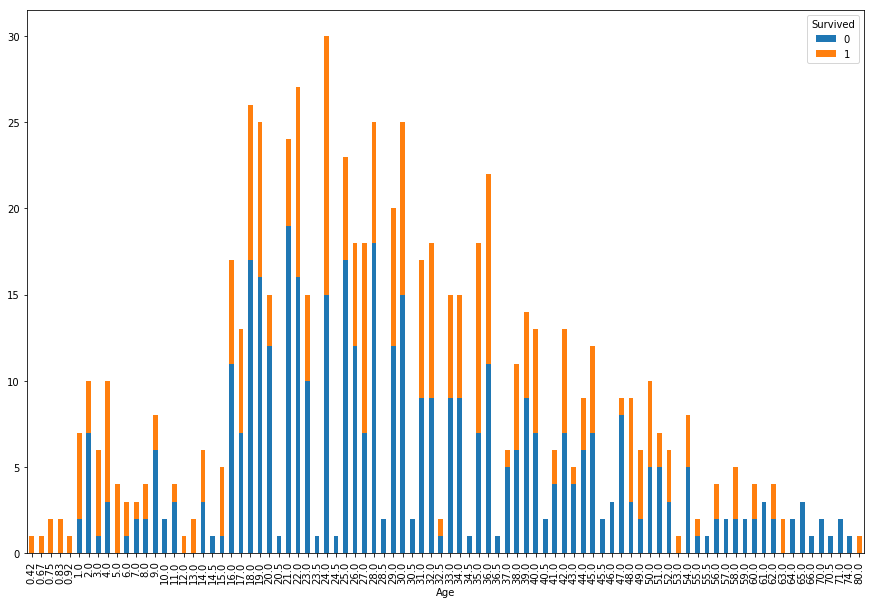

In [18]:
counts = titanic.groupby(['Age', 'Survived']).Age.count().unstack()
counts.plot(kind='bar', stacked=True, figsize=(15,10))

Nothing stands out that much, let's group these ages in groups of ten and see if anything changes

In [19]:
bins = np.arange(0, 100, 10)
labels = list(map(str, bins[:-1]))
labels = [b + 's' for b in labels]
titanic_age_bins = titanic.copy()

titanic_age_bins['AgeBin'] = pd.cut(titanic_age_bins.Age, bins=bins, labels=labels)
titanic_age_bins.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeBin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,20s
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,30s
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,20s
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,30s
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,30s


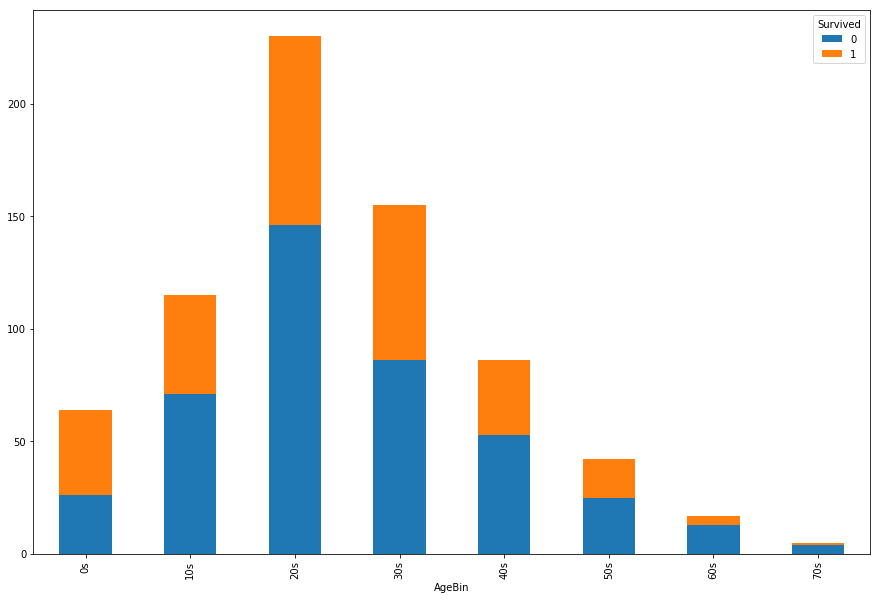

In [20]:
counts = titanic_age_bins.groupby(['AgeBin', 'Survived']).AgeBin.count().unstack()
counts.plot(kind='bar', stacked=True, figsize=(15,10))

This gets a little better, we can see that younger people are more likely to survive till we get to around the mean age, then after that, you start to see survival rate decrease.  Let's take a look at one more thing, let's look at these age bin survivals in respect to the classes

In [21]:
for age_bin in [str(b) + 's' for b in np.arange(0, 80, 10)]:
    print(age_bin, 'survival:')
    temp_bin = titanic_age_bins[titanic_age_bins.AgeBin == age_bin]
    print(temp_bin[temp_bin.Survived == 1].Pclass.value_counts())
    print('Survived / Total in Bin:', len(temp_bin[temp_bin.Survived == 1]) / len(temp_bin))
    print('\n')

0s survival:
3    19
2    17
1     2
Name: Pclass, dtype: int64
Survived / Total in Bin: 0.59375


10s survival:
3    20
1    15
2     9
Name: Pclass, dtype: int64
Survived / Total in Bin: 0.3826086956521739


20s survival:
3    30
1    29
2    25
Name: Pclass, dtype: int64
Survived / Total in Bin: 0.3652173913043478


30s survival:
1    37
2    19
3    13
Name: Pclass, dtype: int64
Survived / Total in Bin: 0.44516129032258067


40s survival:
1    21
2    10
3     2
Name: Pclass, dtype: int64
Survived / Total in Bin: 0.38372093023255816


50s survival:
1    15
2     2
Name: Pclass, dtype: int64
Survived / Total in Bin: 0.40476190476190477


60s survival:
1    2
3    1
2    1
Name: Pclass, dtype: int64
Survived / Total in Bin: 0.23529411764705882


70s survival:
1    1
Name: Pclass, dtype: int64
Survived / Total in Bin: 0.2




So since I'm a newb with pandas and matplotlib manipulation right now, I can't really show this very well
<br />
*TODO  get good with matplotlib and pandas then come back and make a bangin plot*
<br />
But it does kind of seem that young children were more likely to survive; this combined with the **Pclass**, really seems like it could help our model out.  Or maybe it coulnd't.  Who knows, we will will just make a seperate model later.

## **SibSp**

This feature is the number of siblings or spouses this person was with on the Titanic.  The problem is we don't know this number represents siblings or spouses.  Let's first start looking at some of the distributions and see if anything stands out

In [23]:
titanic.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [24]:
titanic[titanic.Survived == 1].SibSp.value_counts() / titanic.SibSp.value_counts()

0    0.345395
1    0.535885
2    0.464286
3    0.250000
4    0.166667
5         NaN
8         NaN
Name: SibSp, dtype: float64

A couple things to break down here.  First with 0 and 1.  With 0, this obviously means the traveler was alone and wouldn't be affected by having a companion.  With 1, I would guess that more times than not, this would be the spouse.  With 0, the survival rate seems to be about what the average survival rate was for the whole titanic.  Which makes sense since the overwhelming majority of people have no spouses or siblings on the ship.  But with 1 the survival average seems to go up quite a bit.  The only explanation for this might be because a woman was prioritized to get off the boat first and maybe they had children which prioritized them even more?  We will look more into this when we look at **Parch** next.

<br />

What does become interesting is the small amount of people that had more than 1 **SibSp**.  I would assume that this meant they had more than one sibling.  And as we can see the survival rate decreased as the number of assumed siblings increased.  This could be because people would likely not want to abandon their siblings.  Let's take a look at a random sample of those with 4 or more **SibSp**

In [39]:
titanic[titanic.SibSp >= 4].sample(10, random_state = 42)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.5500,NaN,S
278,279,0,3,"Rice, Master. Eric",male,7.0,4,1,382652,29.1250,NaN,Q
787,788,0,3,"Rice, Master. George Hugh",male,8.0,4,1,382652,29.1250,NaN,Q
386,387,0,3,"Goodwin, Master. Sidney Leonard",male,1.0,5,2,CA 2144,46.9000,NaN,S
171,172,0,3,"Rice, Master. Arthur",male,4.0,4,1,382652,29.1250,NaN,Q
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.5500,NaN,S
850,851,0,3,"Andersson, Master. Sigvard Harald Elias",male,4.0,4,2,347082,31.2750,NaN,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.5500,NaN,S
233,234,1,3,"Asplund, Miss. Lillian Gertrud",female,5.0,4,2,347077,31.3875,NaN,S
16,17,0,3,"Rice, Master. Eugene",male,2.0,4,1,382652,29.1250,NaN,Q


So all are children and maybe the ones we don't know are as well.  What is interesting is all of these people in our sample are all in 3rd class.  Let's check the **Pclass** distribution for all **SibSp**s greater than 2

In [44]:
titanic[titanic.SibSp > 2].Pclass.value_counts()

3    42
1     3
2     1
Name: Pclass, dtype: int64

So the overwhelming majority of these people that didn't survive were in 3rd class.  Let's see the percentage of each class to survive

In [45]:
titanic[titanic.Survived == 1][titanic.SibSp > 2].Pclass.value_counts() / titanic[titanic.SibSp > 2].Pclass.value_counts()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


3    0.095238
1    0.666667
2    1.000000
Name: Pclass, dtype: float64

We can disregard 2nd class since there was only 1 person in it anyways, but when we look at 3rd class vs 1st class, we can see a very big difference.  It seems that 3rd class people with more than 2 siblings (we assume it's siblings) only survived 1% of the time.  Maybe it seems that 3rd class children not as prioritized as we previously thought.  BUT this could also be due to the fact that the 3rd class was much lower on the ship which flooded first.  Regardless, this could help a lot with determing who survived. 

## **Parch**

Let's now look at **Parch** which is the number of parents or children on the titanic

In [46]:
titanic.Parch.value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [47]:
titanic[titanic.Survived == 1].Parch.value_counts() / titanic.Parch.value_counts()

0    0.343658
1    0.550847
2    0.500000
3    0.600000
4         NaN
5    0.200000
6         NaN
Name: Parch, dtype: float64

With this field we have slightly similar results, with 0 parents or children resulting in about the same survival rate as the entire ship, and with 1 parent or child increasing the survival rate quite a bit.  I believe that there is some similarity between this feature and the **SibSp** feature.  For now, I will not be diving in deaper for this field, but I believe there could be some tricky stuff done with the **Name** (specificall last name), **Age**, **SibSp**, and **Parch** that could help us find more correlations.  But for now, I don't see it contributing all that much.

## **Ticket & Cabin**

I will be dropping both of these fields.  **Ticket** because the values seem to be so scattered and there really isn't any pattern that is very clear.  I thought that **Cabin** could be a cool feature to do stuff with because if we could find the layout of the ship somewhere online, we could maybe determine where the room was in relation to how far away from the hole in the ship it was.  As we saw before, the reason that a lot of people in 3rd class probably died is because they would be lower on the ship.  Now, not all of them died, knowing where their cabin was on the ship could contribute to how likely they were to survive.  They could have been really far from where the ship had a hole in it giving them more time to get to the top of the deck.  Unfortunately, this feature is missing a TON of values.  So we will just be dropping it.

## **Fare**

Fare is a float number that could give us some extra granulatiry (over **Pclass**) on who was richer and therefore who might be more likely to get off the ship.

In [48]:
titanic.Fare.describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [50]:
print('1st class')
print(titanic[titanic.Pclass == 1].Fare.describe())
print('\n')
print('2nd class')
print(titanic[titanic.Pclass == 2].Fare.describe())
print('\n')
print('3rd class')
print(titanic[titanic.Pclass == 3].Fare.describe())

1st class
count    216.000000
mean      84.154687
std       78.380373
min        0.000000
25%       30.923950
50%       60.287500
75%       93.500000
max      512.329200
Name: Fare, dtype: float64


2nd class
count    184.000000
mean      20.662183
std       13.417399
min        0.000000
25%       13.000000
50%       14.250000
75%       26.000000
max       73.500000
Name: Fare, dtype: float64


3rd class
count    491.000000
mean      13.675550
std       11.778142
min        0.000000
25%        7.750000
50%        8.050000
75%       15.500000
max       69.550000
Name: Fare, dtype: float64


I would predict that in the 1st class, those who paid more than the mean **Fare**, had a higher chance of survival because they were richer.  And I would say the same logic could apply to for those who paid under the mean **Fare** in 3rd class but of course with a lower chance of survival.  Let's take a look

In [60]:
survived = titanic[titanic.Survived == 1]

print('Survival rate for all of 1st class')
print(len(survived[titanic.Pclass == 1]) / len(titanic[titanic.Pclass == 1]))
print('Survival rate for of 1st class who paid over mean')
print(len(survived[titanic.Pclass == 1][titanic.Fare > titanic.Fare.mean()]) / len(titanic[titanic.Pclass == 1]))

print('\n')

print('Survival rate for all of 3rd class')
print(len(survived[titanic.Pclass == 3]) / len(titanic[titanic.Pclass == 3]))
print('Survival rate for of 3rd class who paid under mean')
print(len(survived[titanic.Pclass == 3][titanic.Fare < titanic.Fare.mean()]) / len(titanic[titanic.Pclass == 3]))

Survival rate for all of 1st class
0.6296296296296297
Survival rate for of 1st class who paid over mean
0.5046296296296297


Survival rate for all of 3rd class
0.24236252545824846
Survival rate for of 3rd class who paid under mean
0.23217922606924643


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


lol.. whelp that was wrong.  Maybe fare won't have much more of an impact over **Pclass**

## **Embarked**

Finally we have **Embarked**.  This is an object field with 1 of 3 values:
* C - Cherbourg
* Q - Queenstown
* S - Southampton

I don't think there would be any type of correlation between surviving and where you embarked from, but let's just look at the distribution for fun

In [61]:
titanic[titanic.Survived == 1].Embarked.value_counts() / titanic.Embarked.value_counts()

S    0.336957
C    0.553571
Q    0.389610
Name: Embarked, dtype: float64

In [62]:
titanic.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

Hmm, interesting.  Southampton and Queenstown are both around the average, but Cherbourg is a bit higher than the average survival rate, could this be because of the class they were in? 

In [63]:
titanic[titanic.Embarked == 'C'].Pclass.value_counts()

1    85
3    66
2    17
Name: Pclass, dtype: int64

Wow, this is pretty interesting.  let's take a look at the 3rd class survival rate between the different embarkment ports

In [65]:
for port in ['S', 'C', 'Q']:
    print('Port', port)
    print(titanic[titanic.Embarked == port][titanic.Pclass == 3].Survived.value_counts(normalize = True))

Port S
0    0.810198
1    0.189802
Name: Survived, dtype: float64
Port C
0    0.621212
1    0.378788
Name: Survived, dtype: float64
Port Q
0    0.625
1    0.375
Name: Survived, dtype: float64


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


Mmmm maybe it wasn't as interesting as I thought.  But there is a drop from the average survival rate when embarked from port Southampton.  Maybe it will maybe it won't help our model.  Regardless, we are missing a few fields.  Since Southampton is overwhelmingly where most people embarked from, we will just fill in the missing values with that.  